In [1]:
import sys
import os
import glob
sys.path.append('../../..')

from model import processing
price_list = processing.import_binance_prices(assets=['DOT', 'ETH', 'BTC', 'DOGE'], start_date='Nov 1 2022', days=90)
price_list += [price_list[0]] * 10
print(price_list[0:10])

[{'DOT': 6.62, 'ETH': 1572.69, 'BTC': 20490.74, 'DOGE': 0.12685}, {'DOT': 6.63, 'ETH': 1572.69, 'BTC': 20491.49, 'DOGE': 0.12684}, {'DOT': 6.62, 'ETH': 1573.54, 'BTC': 20493.67, 'DOGE': 0.12714}, {'DOT': 6.62, 'ETH': 1573.09, 'BTC': 20490.01, 'DOGE': 0.12679}, {'DOT': 6.62, 'ETH': 1571.2, 'BTC': 20475.95, 'DOGE': 0.1262}, {'DOT': 6.62, 'ETH': 1571.44, 'BTC': 20474.28, 'DOGE': 0.12611}, {'DOT': 6.62, 'ETH': 1570.52, 'BTC': 20466.76, 'DOGE': 0.12578}, {'DOT': 6.61, 'ETH': 1570.53, 'BTC': 20466.56, 'DOGE': 0.12568}, {'DOT': 6.62, 'ETH': 1570.46, 'BTC': 20466.56, 'DOGE': 0.12579}, {'DOT': 6.62, 'ETH': 1570.24, 'BTC': 20464.07, 'DOGE': 0.12587}]


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, price, usd_price, dynamicadd_asset_fee, dynamicadd_lrna_fee, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth, extra_trade_volume, trade_to_slippage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20},
    'DOGE': {'usd price': price_list[0]['DOGE'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            # oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
            lrna_fee=0,
            asset_fee=0,
        )
    },
    agents = {
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'ETH': 1000000000, 'BTC': 3000000000, 'DOGE': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3
            ) + trade_to_slippage(pool_id='omnipool', slippage=0.01, trade_chance=(1e-4)/3.5)
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all = False
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')

test_results = []

def pass_along(min_value, max_value, steps, current):
    return min_value + min(max_value - min_value, 1) * current ** 2 / (steps - 1 or 1) ** 2

trade_volume=10
for fee in [pass_along(0.0, 0.1, 25, i) for i in range(25)]:
    random.seed(42)
    test_state = initial_state.copy()
    test_state.pools['omnipool'].lrna_fee = fee
    test_state.pools['omnipool'].asset_fee = fee * 5
    # test_state.agents['Trader'].trade_strategy += extra_trade_volume('omnipool', percent_of_arb=50)  # , percent_of_pool=1 / initial_omnipool_tvl * trade_volume )
    events = run.run(test_state, time_steps=time_steps)
    # print(events[-1])
    LP_returns = cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market)
    total_volume=[sum(event.pools['omnipool'].volume_in.values()) + sum(event.pools['omnipool'].volume_out.values()) for event in events]
    test_results.append((trade_volume, fee, LP_returns, total_volume))
    print(f'lrna fee = {fee}, asset fee = {fee * 5}, trade volume = {sum(total_volume)}')
    print(f'returns = {LP_returns}')
    
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 647597 time steps
Starting simulation...
Execution time: 218.179 seconds.
lrna fee = 0.0, asset fee = 0.0, trade volume = 2337836469.787284
returns = 982646.6790568186
Starting simulation...
Execution time: 66.179 seconds.
lrna fee = 0.00017361111111111112, asset fee = 0.0008680555555555556, trade volume = 739318065.3773245
returns = 990500.9363383318
Starting simulation...
Execution time: 57.83 seconds.
lrna fee = 0.0006944444444444445, asset fee = 0.0034722222222222225, trade volume = 221564920.16603693
returns = 998771.1153311153
Starting simulation...
Execution time: 61.03 seconds.
lrna fee = 0.0015625, asset fee = 0.0078125, trade volume = 98888043.119449
returns = 1005220.2674068899
Starting simulation...
Execution time: 58.427 seconds.
lrna fee = 0.002777777777777778, asset fee = 0.01388888888888889, trade volume = 58110970.35324867
returns = 1005528.6642563725
Starting simulation...
Execution time: 56.136 seconds.
lrna fee = 0.004340277777777778, asset fee = 0.0217

In [3]:
# lines = []
# with open('./output/test_results_static_fees_dec.txt', 'r') as file:
#     data = file.readlines()
#     lines = [float(line [10: 20]) for line in list(filter(lambda line: line[0] == 'r', data))]
    
# print(len(lines))
# print(lines)
# test_results = [lines[i * 10: i * 10 + 10] for i in range(10)]

In [4]:
# print(test_results[0])

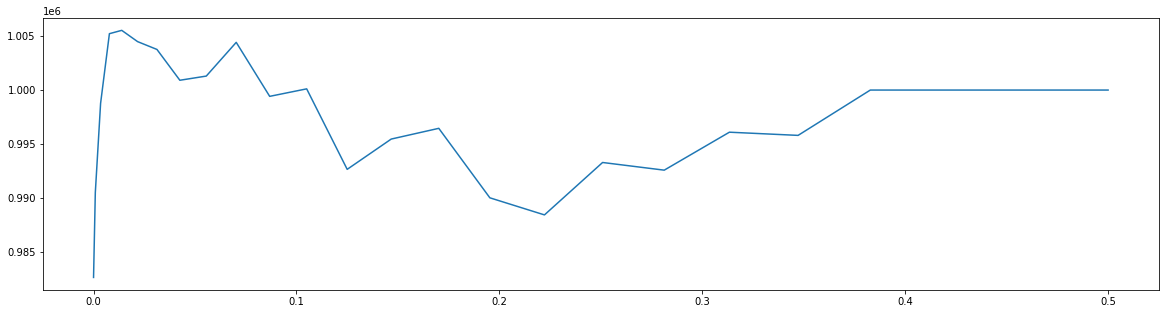

In [5]:
colors = pu.color_gradient(25)
plt.figure(figsize=(20, 5))
plt.plot([result[1] * 5 for result in test_results], [result[2] for result in test_results])

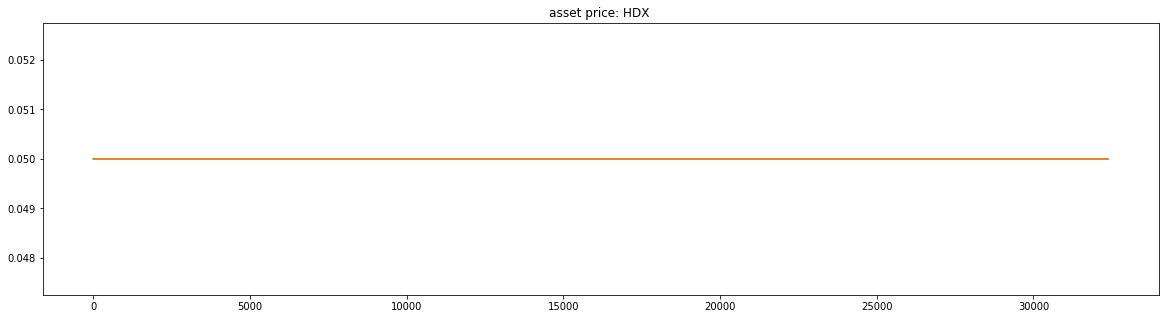

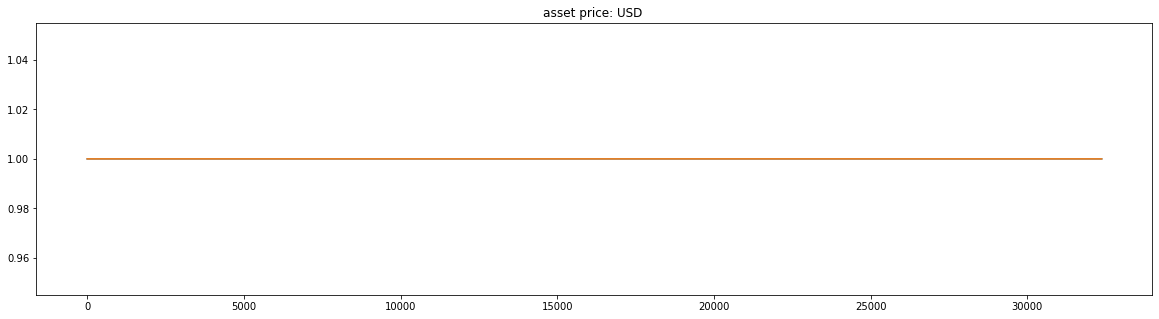

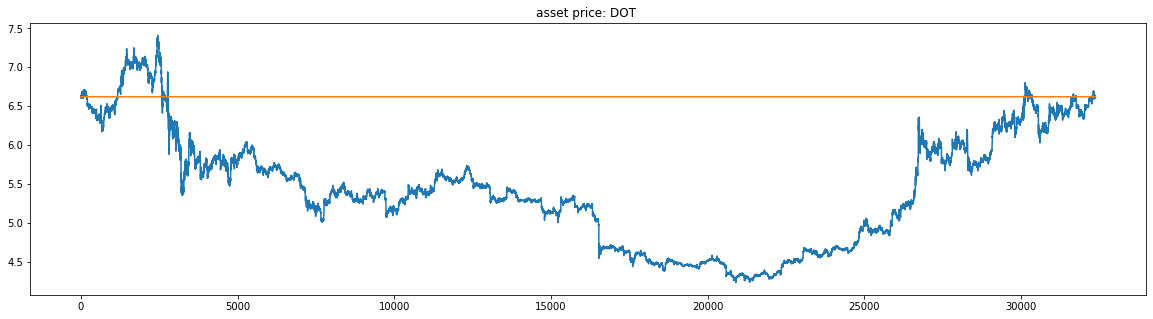

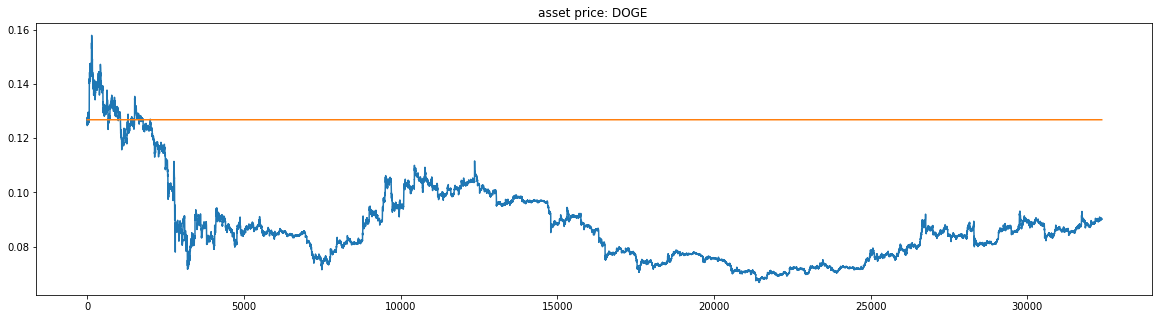

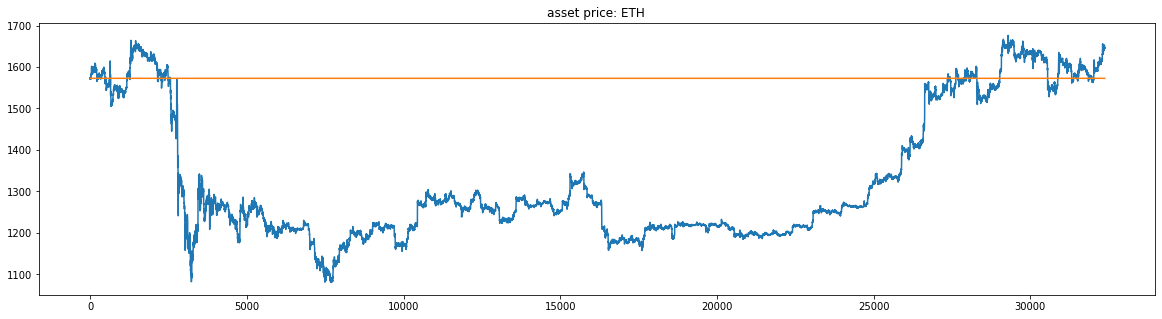

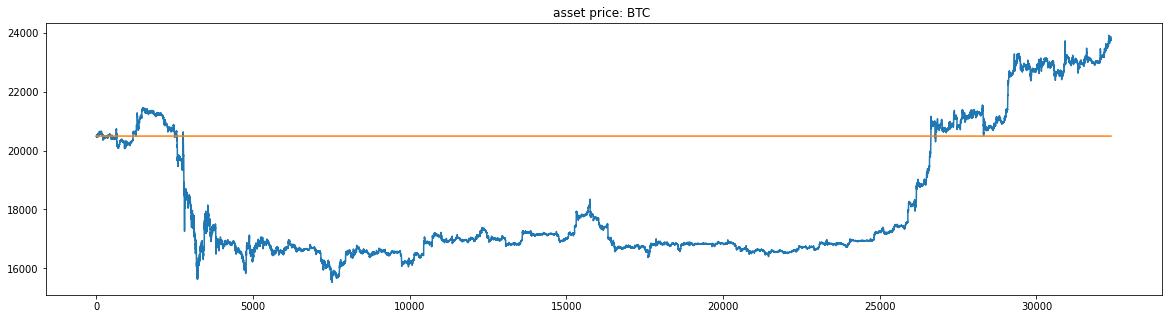

In [6]:
for tkn in initial_state.pools['omnipool'].asset_list:
    ax=pu.plot(events[::20], asset=tkn)
    pu.plot(events[::20], pool='omnipool', prop='usd_price', key=tkn, subplot=ax)

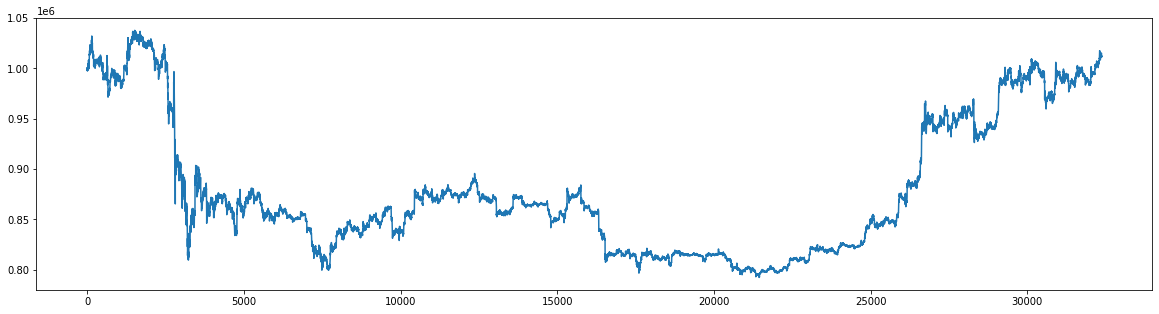

In [7]:
plt.figure(figsize=(20, 5))
from model.amm.omnipool_amm import cash_out_omnipool
plt.plot(range(len(events[::20])), [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events[::20]])

In [8]:
import copy
ordered_results = copy.copy(test_results)
ordered_results.sort(key=lambda x: x[2])
pprint([result[:3] for result in ordered_results])

[(10, 0.0, 982646.6790568186),
 (10, 0.044444444444444446, 988438.4983250487),
 (10, 0.0390625, 990020.6828976503),
 (10, 0.00017361111111111112, 990500.9363383318),
 (10, 0.056249999999999994, 992582.1630608465),
 (10, 0.025, 992657.8710245634),
 (10, 0.05017361111111111, 993292.3270514924),
 (10, 0.02934027777777778, 995461.6300995703),
 (10, 0.06944444444444445, 995802.5152980671),
 (10, 0.06267361111111111, 996097.3825670462),
 (10, 0.03402777777777778, 996455.3388876251),
 (10, 0.0006944444444444445, 998771.1153311153),
 (10, 0.017361111111111112, 999417.1345631769),
 (10, 0.0765625, 1000000.0000000009),
 (10, 0.08402777777777778, 1000000.0000000009),
 (10, 0.09184027777777778, 1000000.0000000009),
 (10, 0.1, 1000000.0000000009),
 (10, 0.021006944444444446, 1000111.1269168912),
 (10, 0.008506944444444445, 1000907.3019401581),
 (10, 0.011111111111111112, 1001294.6893796228),
 (10, 0.00625, 1003760.1062661791),
 (10, 0.014062499999999999, 1004416.9279243036),
 (10, 0.004340277777777

In [9]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].asset_fee=0.025
basic_state.pools['omnipool'].lrna_fee=0.005

basic_events = run.run(basic_state, time_steps=time_steps)


Starting simulation...
Execution time: 56.731 seconds.


<AxesSubplot:title={'center':'asset price: ETH '}>

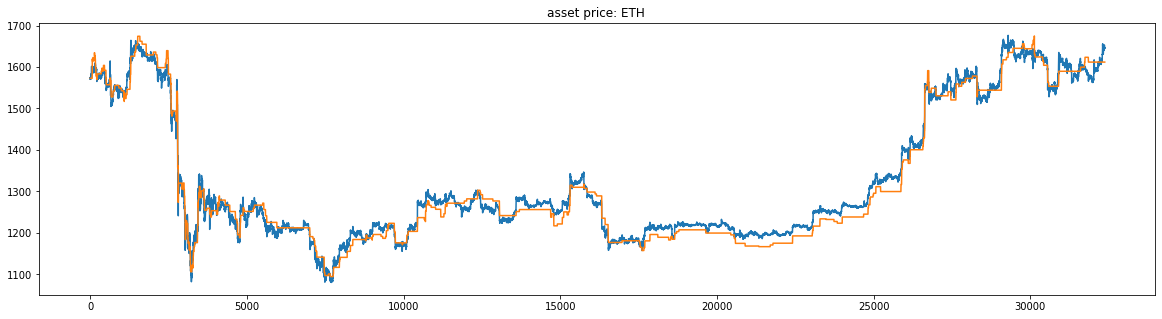

In [10]:
ax=pu.plot(basic_events[::20], asset='ETH')
pu.plot(basic_events[::20], pool='omnipool', prop='usd_price', key='ETH', subplot=ax)

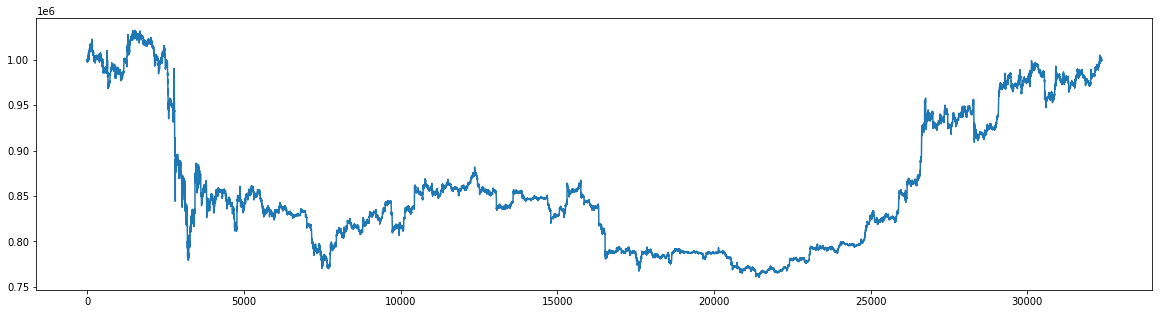

In [11]:
plt.figure(figsize=(20, 5))
LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in basic_events[::20]]


plt.plot(range(len(LP_holdings)), LP_holdings)


[0.0, 0.00017361111111111112, 0.0006944444444444445, 0.0015625, 0.002777777777777778, 0.004340277777777778, 0.00625, 0.008506944444444445, 0.011111111111111112, 0.014062499999999999, 0.017361111111111112, 0.021006944444444446, 0.025, 0.02934027777777778, 0.03402777777777778, 0.0390625, 0.044444444444444446, 0.05017361111111111, 0.056249999999999994, 0.06267361111111111, 0.06944444444444445, 0.0765625, 0.08402777777777778, 0.09184027777777778, 0.1]


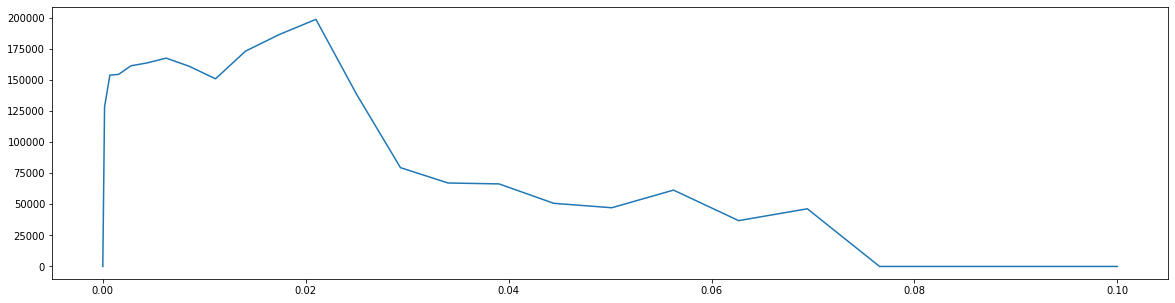

In [12]:
print([result[1] for result in test_results])
plt.figure(figsize=(20, 5))
plt.plot([result[1] for result in test_results], [sum(result[3]) * result[1] for result in test_results])
# plt.yscale('log')

In [13]:
plt.figure(figsize=(20, 5))
LP_holdings1 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events[::20]]
LP_holdings2 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events2[::20]]
LP_holdings3 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events3[::20]]

plt.plot(range(len(LP_holdings1)), LP_holdings1)
plt.plot(range(len(LP_holdings2)), LP_holdings2)
plt.plot(range(len(LP_holdings2)), LP_holdings3)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green)')

NameError: name 'events2' is not defined

<Figure size 1440x360 with 0 Axes>

In [ ]:
print(test_results[1])



In [ ]:
random.seed(42)
basic_state2 = initial_state.copy()
basic_state2.pools['omnipool'].asset_fee=0.0025
basic_state2.pools['omnipool'].lrna_fee=0.0005

events4=run.run(basic_state2, time_steps=time_steps)
LP_holdings4 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events4[::20]]


In [ ]:
random.seed(42)
basic_state3 = initial_state.copy()
basic_state3.pools['omnipool'].asset_fee=0.0025
basic_state3.pools['omnipool'].lrna_fee=0.0005

events5=run.run(basic_state3, time_steps=time_steps)
LP_holdings5 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events5[::20]]


In [ ]:

print(LP_holdings1[-1])
print(LP_holdings2[-1])
print(LP_holdings3[-1])
print(LP_holdings4[-1])
print(LP_holdings5[-1])


In [ ]:
# print(events[0], events[1000])

In [ ]:
print(winning_state, losing_state)

In [ ]:
pu.plot(events, asset='DOGE')

In [ ]:
ax = pu.plot(events, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT')
pu.plot(events2, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT', subplot=ax)

In [ ]:
print(test_results[0])
print(test_results[-1])

In [ ]:
volume_out_usd = [event.pools['omnipool'].oracles['fee_raise'].price['USD'] for event in events3]
plt.plot(range(len(volume_out_usd)), volume_out_usd)

In [ ]:
reverse_price_list = list(reversed(processing.import_binance_prices(assets=['DOT', 'ETH', 'BTC', 'DOGE'], start_date='Nov 1 2022', days=30)))
reverse_basic_state = initial_state.copy()
reverse_basic_state._evolve_function=historical_prices(reverse_price_list)
reverse_basic_events = run.run(reverse_basic_state, time_steps = time_steps)

reverse_state = reverse_basic_state.copy()
reverse_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[-1].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].lrna_decay,
    fee_max=test_results[-1].lrna_max,
)
reverse_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[-1].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].asset_decay,
    fee_max=test_results[-1].asset_max,
)
reverse_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
reverse_events = run.run(reverse_state, time_steps = time_steps)

worst_reverse_state = reverse_state.copy()
worst_reverse_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[0].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].lrna_decay,
    fee_max=test_results[0].lrna_max,
)
worst_reverse_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[0].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].asset_decay,
    fee_max=test_results[0].asset_max,
)
worst_reverse_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
worst_reverse_events = run.run(worst_reverse_state, time_steps = time_steps)


In [ ]:
reverse_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in reverse_events[::20]]
worst_reverse_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in worst_reverse_events[::20]]
reverse_basic_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in reverse_basic_events[::20]]
plt.figure(figsize=(20, 5))
plt.plot(range(len(reverse_LP_holdings)), reverse_basic_LP_holdings)
plt.plot(range(len(reverse_LP_holdings)), reverse_LP_holdings)
plt.plot(range(len(reverse_LP_holdings)), worst_reverse_LP_holdings)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green) with price movement reversed')

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(price_list)), [price_list[i]['ETH'] for i in range(len(price_list))])
plt.plot(range(len(price_list)), [reverse_price_list[i]['ETH'] for i in range(len(price_list))])
plt.title('two different, opposite price runs')

In [ ]:
pu.plot(reverse_events, asset='ETH')

In [ ]:
pu.plot(reverse_events[::100], agent='Trader', prop='holdings', key='ETH')

In [ ]:
oracle = [event.pools['omnipool'].oracles['fee_raise'].volume_in['ETH'] for event in reverse_events][:100]
plt.plot(range(len(oracle)), oracle)

In [ ]:
pu.plot(reverse_events[::20], pool='omnipool', prop='last_fee')
pu.plot(reverse_events[::20], pool='omnipool', prop='last_lrna_fee')

pu.plot(events2[::20], pool='omnipool', prop='last_fee')
pu.plot(events2[::20], pool='omnipool', prop='last_lrna_fee')


In [ ]:
print('hi')


In [ ]:
print(events2[0])


In [ ]:
no_archive_state = basic_state.copy()
no_archive_state.archive_all = True
short_events_1 = run.run(no_archive_state, time_steps = 1)
short_events_2 = run.run(no_archive_state, time_steps = 1)
short_events_3 = run.run(no_archive_state, time_steps = 1)
short_events_4 = run.run(no_archive_state, time_steps = 1)


In [ ]:
print(repr(short_events_1[0]) == repr(short_events_2[0]))
print(short_events_1[0])
print(short_events_2[0])
# state1 = repr(short_events_1[0])
# state2 = repr(short_events_2[0])
# for i, char in enumerate(state1):
#     if char != state2[i]:
#         print(char)
